In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [3]:
class Generator(nn.Module):
    def __init__(self, size_z, num_feature_maps, num_color_channels):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.ConvTranspose2d(size_z, num_feature_maps * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(num_feature_maps * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_feature_maps*4, num_feature_maps * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_feature_maps * 2, num_feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_feature_maps, num_color_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        output = self.network(input)
        return output


class Discriminator(nn.Module):
    def __init__(self, num_feature_maps, num_color_channels):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(

            nn.Conv2d(num_color_channels, num_feature_maps, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(num_feature_maps, num_feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(num_feature_maps * 2, num_feature_maps * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(num_feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(num_feature_maps * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(1)
        
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
batch_size = 128
num_classes = 10
learning_rate = 0.002
num_epochs = 100
num_color_channels = 1
num_feature_maps_g = 32
num_feature_maps_d = 32
size_z = 100
adam_beta1 = 0.2
num_gpu = 0

In [5]:
generator = Generator(size_z=size_z,
                      num_feature_maps=num_feature_maps_g,
                      num_color_channels=num_color_channels).to(device)
discriminator = Discriminator(num_feature_maps=num_feature_maps_d,
                              num_color_channels=num_color_channels).to(device)

In [6]:
# %cd /content/drive/My Drive/Colab/
# !ls
generator.load_state_dict(torch.load("./saved_models/generator.pkl", map_location=torch.device(device)))
discriminator.load_state_dict(torch.load('./saved_models/discriminator.pkl', map_location=torch.device(device)))

<All keys matched successfully>

In [7]:
data = datasets.MNIST(
    root = "data",
    transform = transforms.ToTensor(),
    train=False,
    download=True
)

In [8]:
def get_anomaly_score(x_query, g_z):
    x_prop = discriminator(x_query)
    g_z_prop = discriminator(g_z)

    loss_residual = torch.sum(torch.abs(x_query - g_z))
    loss_discriminative = torch.sum(torch.abs(x_prop - g_z_prop))

    return (1-.1)*loss_residual + .1* loss_discriminative

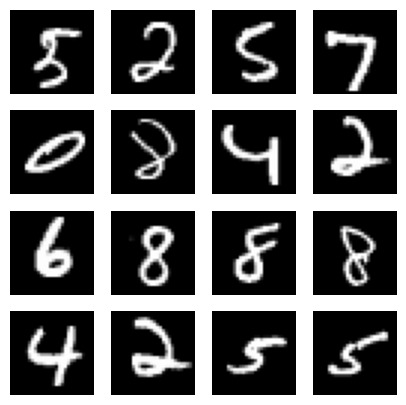

In [9]:
figure = plt.figure(figsize=(5, 5))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(data), size=(1,)).item()
    img, label = data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [10]:
from torch.autograd import Variable
import torch.nn.init as init

start_idx = 64
test_size = 8

test_data_mnist = data.__dict__['data'][start_idx:start_idx+test_size]
test_data_mnist = test_data_mnist.view(test_size,1,28,28).type_as(torch.FloatTensor())
test_data_mnist.size()



torch.Size([8, 1, 28, 28])

In [11]:
# z = Variable(init.normal(torch.zeros(test_size,100,1,1),mean=0.5,std=0.5),requires_grad=True)
z = torch.randn(8, size_z, 1, 1, device=device)
z_optimizer = torch.optim.Adam([z],lr=1e-4)

gen_fake = generator(z.to(device))
loss = get_anomaly_score(Variable(test_data_mnist).to(device), gen_fake)
# print(loss)

In [12]:
for i in range(5000):
    gen_fake = generator(z.to(device))
    loss = get_anomaly_score(Variable(test_data_mnist).to(device),gen_fake)
    loss.backward()
    z_optimizer.step()

    if i%1000==0:
        print(loss.data)
        '''
        target = test_data_mnist[1,0,:,:].numpy()
        plt.imshow(target,cmap="gray")
        plt.show()

        img=gen_fake.cpu().data[1,0,:,:].numpy()
        plt.imshow(img,cmap='gray')
        plt.show()
        '''



tensor(202620.7812)
tensor(202620.7812)
tensor(202620.7812)
tensor(202620.7812)
tensor(202620.7812)


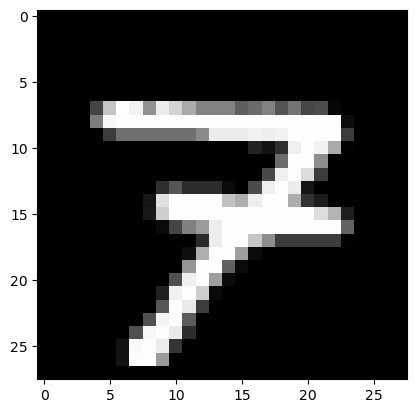

real data


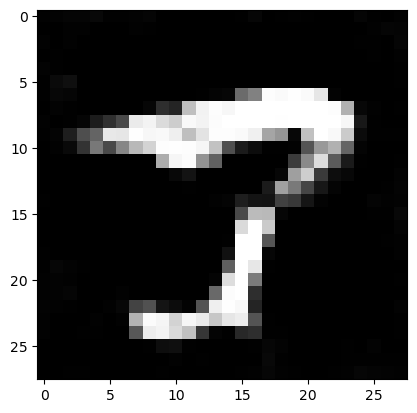

generated data

------------------------------------



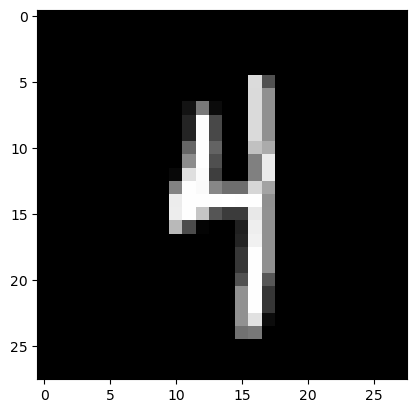

real data


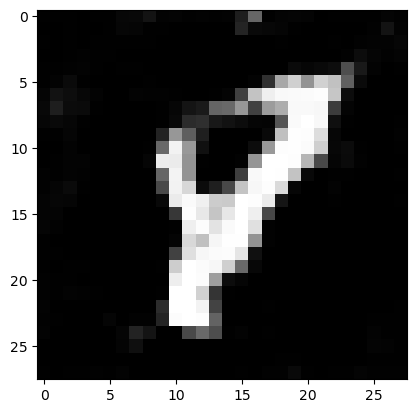

generated data

------------------------------------



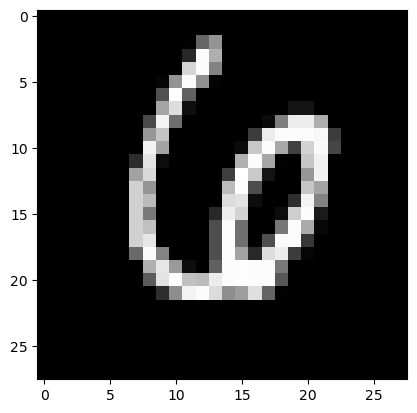

real data


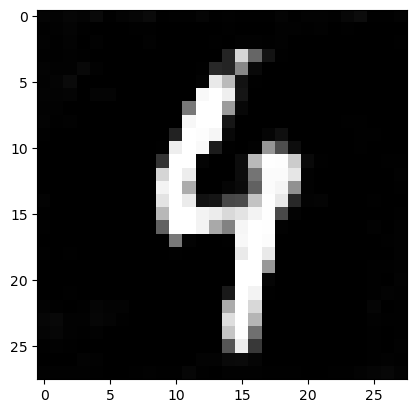

generated data

------------------------------------



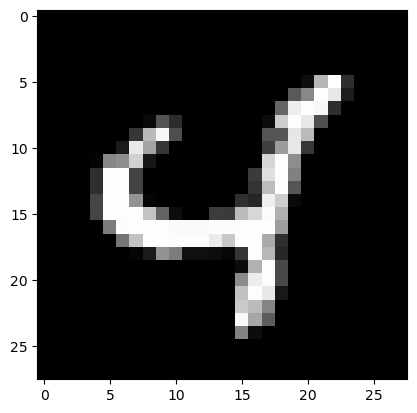

real data


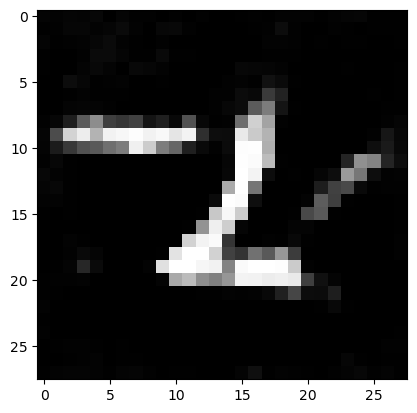

generated data

------------------------------------



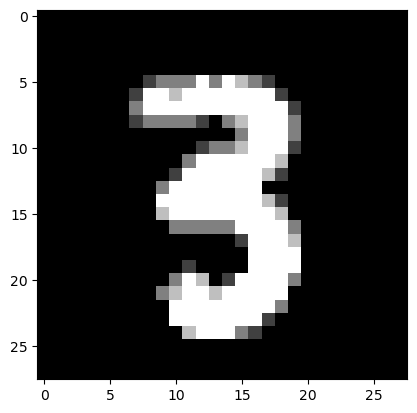

real data


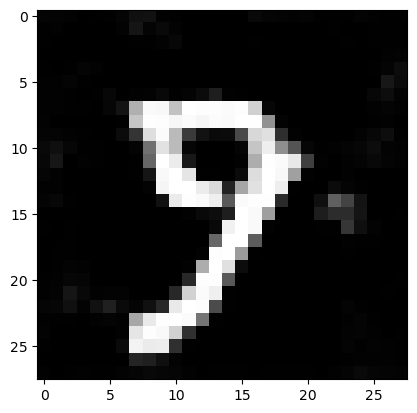

generated data

------------------------------------



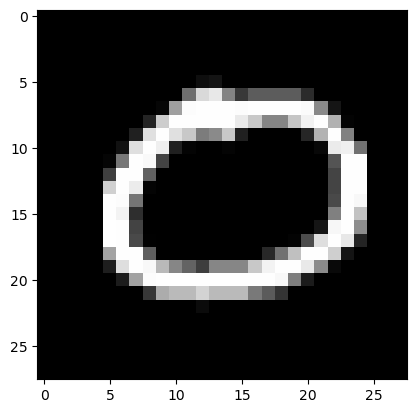

real data


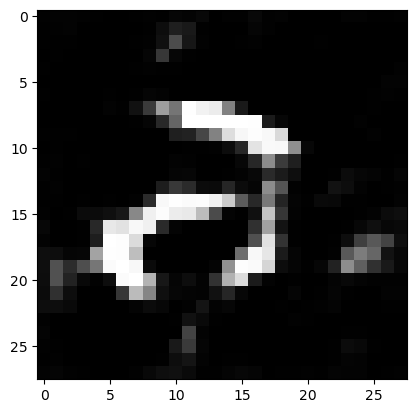

generated data

------------------------------------



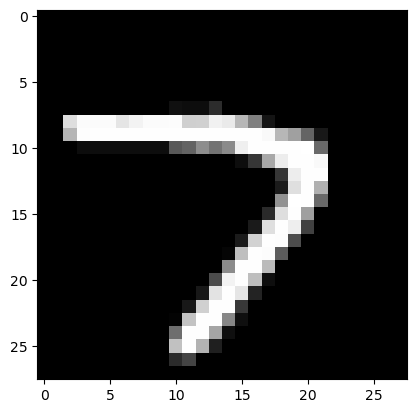

real data


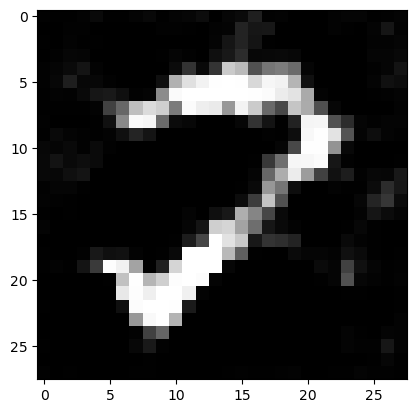

generated data

------------------------------------



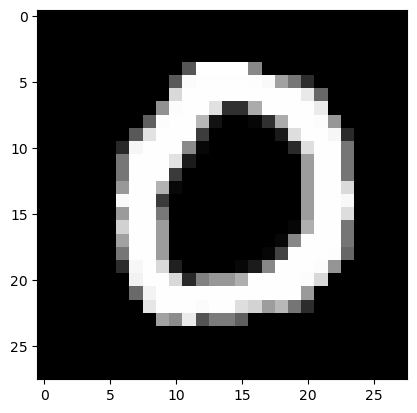

real data


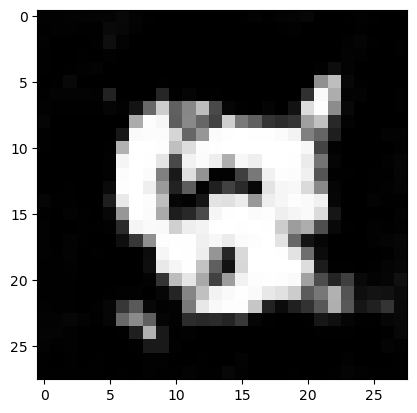

generated data

------------------------------------



In [13]:
for idx in range(test_size):
    target = test_data_mnist[idx,0,:,:].numpy()
    plt.imshow(target,cmap="gray")
    plt.show()
    print("real data")

    img=gen_fake.cpu().data[idx,0,:,:].numpy()
    plt.imshow(img,cmap='gray')
    plt.show()
    print("generated data")
    print("\n------------------------------------\n")